# Colab part

## Download the data

In [ ]:
import gdown

In [ ]:
sharing_link_train = "https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing"
gdown.download(url=sharing_link_train, output="./data_train.zip", quiet=False, fuzzy=True)

sharing_link_test = "https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing"
gdown.download(url=sharing_link_test, output="./data_test.zip", quiet=False, fuzzy=True)

!unzip -o -qq data_train.zip -d train_data
!unzip -o -qq data_test.zip -d test_data

Downloading...
From (original): https://drive.google.com/uc?id=1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16
From (redirected): https://drive.google.com/uc?id=1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16&confirm=t&uuid=47dff30a-a6c5-473b-94be-93114ddef60a
To: /content/data_train.zip
100%|██████████| 2.28G/2.28G [00:37<00:00, 60.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K
From (redirected): https://drive.google.com/uc?id=12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K&confirm=t&uuid=5469eb66-1ea3-4f34-b881-3d73c2b80324
To: /content/data_test.zip
100%|██████████| 222M/222M [00:04<00:00, 49.3MB/s]


## Data preprocessing

In [ ]:
import os

import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [ ]:
emotions = os.listdir('./train_data/train/')
idx2emotions = {i:v for i, v in enumerate(emotions)}
emotions2idx = {v:i for i, v in enumerate(emotions)}

all_train_images = []
all_train_labels = []
for emotion in emotions:
    for filename in os.listdir('./train_data/train/'+emotion):
        all_train_images.append('./train_data/train/'+emotion+'/'+filename)
        all_train_labels.append(emotions2idx[emotion])

train_images, test_images, train_labels, test_labels = train_test_split(
    all_train_images,
    all_train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [ ]:
num_samples_list = []
label_list = []
for emotion in emotions:
    num_samples = len(os.listdir('./train_data/train/'+emotion))
    label_list.append(emotion)
    num_samples_list.append(num_samples)

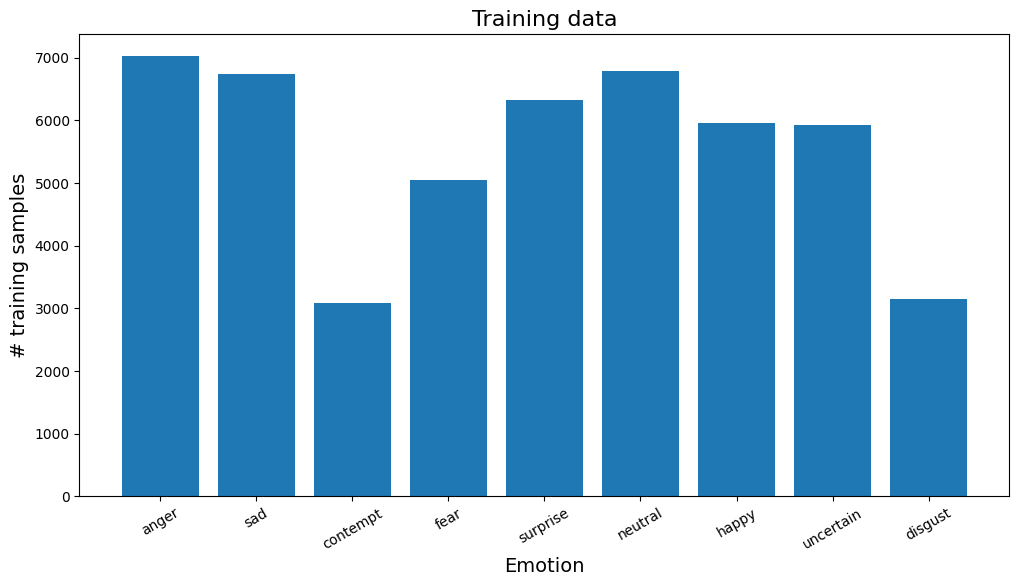

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(label_list, num_samples_list)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('# training samples', fontsize=14)
plt.title('Training data', fontsize=16)
plt.xticks(rotation=30)
plt.show()

## Dalaset and dataloader

In [ ]:
class MyTrainDataset(Dataset):

    def __init__(self, images, labels, img_size=48, to_float=True):
        self.images = images
        self.labels = labels
        self.to_float = to_float
        self.transform = T.Compose([T.ToTensor(), T.Resize((img_size,img_size))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]
        image = self.transform(Image.open(img_name))
        if self.to_float:
            image = image / 255.
        return image, label

In [ ]:
batch_size = 32

train_dataset = MyTrainDataset(images=train_images, labels=train_labels)
test_dataset = MyTrainDataset(images=test_images, labels=test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Model

In [ ]:
from torch import nn
from torchvision import models

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=9, embedding_len=256):
        super(Net, self).__init__()
        self.pretrained = models.resnet34(weights='IMAGENET1K_V1')
        self.embedding = torch.nn.Linear(1000, embedding_len)
        self.bn = torch.nn.BatchNorm1d(embedding_len)
        self.output = torch.nn.Linear(embedding_len, num_classes)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.embedding(x)
        x = self.bn(x)
        x = self.output(x)
        return x

## Train and test functions

In [ ]:
import torch
from tqdm import tqdm

In [ ]:
def train(model, criterion, batch_size, device, train_loader, optimizer, epoch):

    model.train()
    running_loss = 0.0
    running_corrects = 0.0

    print(f"---------- Epoch {epoch} ----------")

    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / (len(train_loader)*batch_size)
    epoch_acc = running_corrects / (len(train_loader)*batch_size)

    print('TRAIN: epoch {} loss: {:.4f}, acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))


def test(model, criterion, batch_size, device, test_loader):

    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    print(f"---------- Testing ----------")

    for batch_idx, (inputs, labels) in enumerate(tqdm(test_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / (len(test_loader)*batch_size)
    epoch_acc = running_corrects / (len(test_loader)*batch_size)

    print('TEST: loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))

## Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
model = torch.load('resnet_34_7e.pth')
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 5

In [ ]:
for i in range(num_epochs):
    train(model, criterion, batch_size, device, train_loader, optimizer, i)
    test(model, criterion, batch_size, device, test_loader)

---------- Epoch 0 ----------


100%|██████████| 1252/1252 [06:36<00:00,  3.16it/s]


TRAIN: epoch 0 loss: 1.8589, acc: 0.3245
---------- Testing ----------


100%|██████████| 313/313 [01:38<00:00,  3.18it/s]


TEST: loss: 1.7260, acc: 0.3763
---------- Epoch 1 ----------


100%|██████████| 1252/1252 [06:31<00:00,  3.20it/s]


TRAIN: epoch 1 loss: 1.6433, acc: 0.4060
---------- Testing ----------


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


TEST: loss: 1.6415, acc: 0.4040
---------- Epoch 2 ----------


100%|██████████| 1252/1252 [06:39<00:00,  3.14it/s]


TRAIN: epoch 2 loss: 1.5326, acc: 0.4483
---------- Testing ----------


100%|██████████| 313/313 [01:35<00:00,  3.28it/s]


TEST: loss: 1.6230, acc: 0.4062
---------- Epoch 3 ----------


100%|██████████| 1252/1252 [06:41<00:00,  3.12it/s]


TRAIN: epoch 3 loss: 1.4230, acc: 0.4899
---------- Testing ----------


100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


TEST: loss: 1.7058, acc: 0.3943
---------- Epoch 4 ----------


100%|██████████| 1252/1252 [06:36<00:00,  3.16it/s]


TRAIN: epoch 4 loss: 1.3026, acc: 0.5341
---------- Testing ----------


100%|██████████| 313/313 [01:39<00:00,  3.15it/s]


TEST: loss: 1.6615, acc: 0.4198
---------- Epoch 5 ----------


100%|██████████| 1252/1252 [06:20<00:00,  3.29it/s]


TRAIN: epoch 5 loss: 1.1537, acc: 0.5874
---------- Testing ----------


100%|██████████| 313/313 [01:34<00:00,  3.30it/s]


TEST: loss: 1.7731, acc: 0.4270
---------- Epoch 6 ----------


100%|██████████| 1252/1252 [06:29<00:00,  3.21it/s]


TRAIN: epoch 6 loss: 0.9684, acc: 0.6574
---------- Testing ----------


100%|██████████| 313/313 [01:37<00:00,  3.21it/s]

TEST: loss: 1.9437, acc: 0.4121


In [ ]:
train_acc = [0.3245, 0.4060, 0.4483, 0.4899, 0.5341, 0.5874, 0.6574]
test_acc = [0.3763, 0.4040, 0.4062, 0.3943, 0.4198, 0.4270, 0.4121]
train_loss = [1.8589, 1.6433, 1.5326, 1.4230, 1.3026, 1.1537, 0.9684]
test_loss = [1.7260, 1.6415, 1.6230, 1.7058, 1.6615, 1.7731, 1.9437]

In [ ]:
torch.save(model, 'resnet_34_7e.pth')

In [ ]:
for i in range(num_epochs):
    train(model, criterion, batch_size, device, train_loader, optimizer, i+7)
    test(model, criterion, batch_size, device, test_loader)

---------- Epoch 7 ----------


100%|██████████| 1252/1252 [07:03<00:00,  2.96it/s]


TRAIN: epoch 7 loss: 1.0804, acc: 0.6394
---------- Testing ----------


100%|██████████| 313/313 [01:43<00:00,  3.01it/s]


TEST: loss: 1.0649, acc: 0.6375
---------- Epoch 8 ----------


100%|██████████| 1252/1252 [06:56<00:00,  3.01it/s]


TRAIN: epoch 8 loss: 0.8102, acc: 0.7274
---------- Testing ----------


100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


TEST: loss: 1.5571, acc: 0.5936
---------- Epoch 9 ----------


100%|██████████| 1252/1252 [06:23<00:00,  3.27it/s]


TRAIN: epoch 9 loss: 0.6141, acc: 0.7925
---------- Testing ----------


100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


TEST: loss: 1.4087, acc: 0.5819
---------- Epoch 10 ----------


100%|██████████| 1252/1252 [06:33<00:00,  3.19it/s]


TRAIN: epoch 10 loss: 0.4670, acc: 0.8428
---------- Testing ----------


100%|██████████| 313/313 [01:35<00:00,  3.27it/s]


TEST: loss: 1.4113, acc: 0.5746
---------- Epoch 11 ----------


100%|██████████| 1252/1252 [06:30<00:00,  3.20it/s]


TRAIN: epoch 11 loss: 0.3785, acc: 0.8729
---------- Testing ----------


100%|██████████| 313/313 [01:34<00:00,  3.32it/s]

TEST: loss: 1.6917, acc: 0.5596


In [ ]:
torch.save(model, 'resnet_34_12e.pth')

In [ ]:
train_acc = [0.3245, 0.4060, 0.4483, 0.4899, 0.5341, 0.5874, 0.6574, 0.6394, 0.7274, 0.7925, 0.8428, 0.8729]
test_acc = [0.3763, 0.4040, 0.4062, 0.3943, 0.4198, 0.4270, 0.4121, 0.6375, 0.5936, 0.5819, 0.5746, 0.5596]
train_loss = [1.8589, 1.6433, 1.5326, 1.4230, 1.3026, 1.1537, 0.9684, 1.0804, 0.8102, 0.6141, 0.4670, 0.3785]
test_loss = [1.7260, 1.6415, 1.6230, 1.7058, 1.6615, 1.7731, 1.9437, 1.0649, 1.5571, 1.4087, 1.4113, 1.6917]

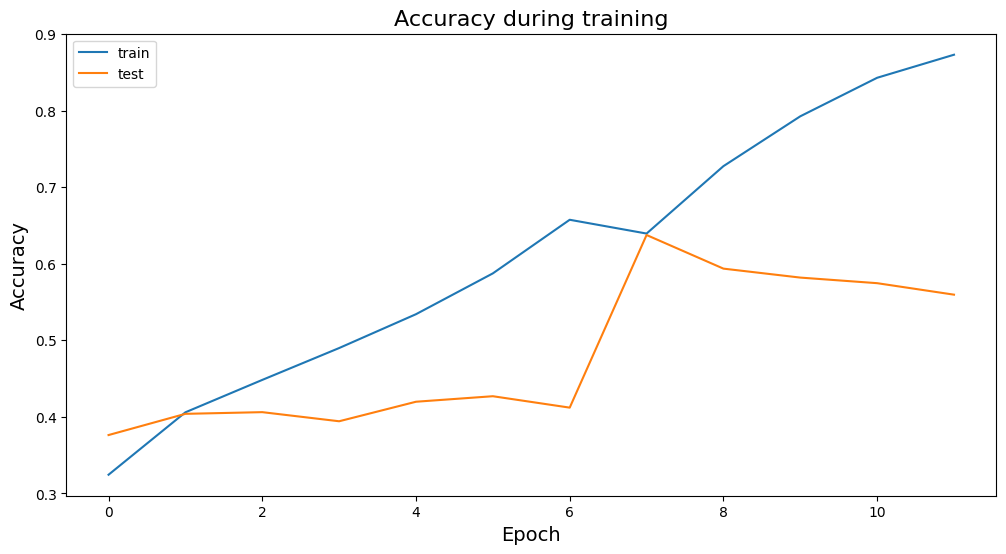

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train_acc, label='train')
ax.plot(test_acc, label='test')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy during training', fontsize=16)
plt.legend()
plt.show()

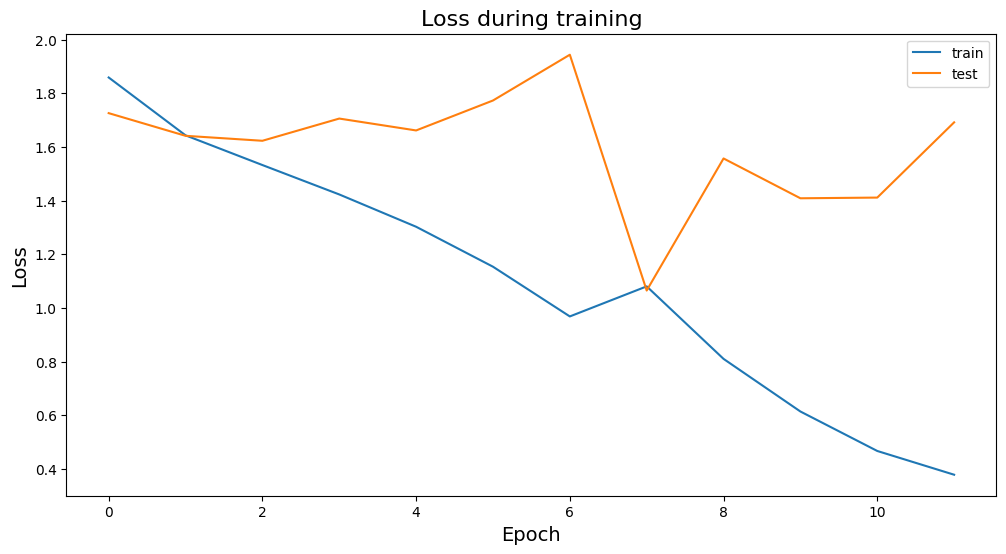

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train_loss, label='train')
ax.plot(test_loss, label='test')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss during training', fontsize=16)
plt.legend()
plt.show()

## Completing submission

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

In [ ]:
class MyPredictDataset(Dataset):

    def __init__(self, images, img_size=48, to_float=True):
        self.images = images
        self.to_float = to_float
        self.transform = T.Compose([T.ToTensor(), T.Resize((img_size,img_size))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = self.transform(Image.open(img_name))
        if self.to_float:
            image = image / 255.
        return image

In [ ]:
submit_images = ['./test_data/test_kaggle/'+str(i)+'.jpg' for i in range(len(os.listdir('./test_data/test_kaggle')))]

batch_size = 32

submit_dataset = MyPredictDataset(images=submit_images)
submit_loader = DataLoader(submit_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def predict(model, batch_size, device, submit_loader):

    model.eval()
    predictions = np.array([])

    print(f"---------- Predicting ----------")

    for _, (inputs) in enumerate(tqdm(submit_loader)):

        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions = np.concatenate([predictions, preds.cpu()])

    return predictions

In [ ]:
model_2 = torch.load('resnet_34_12e.pth')

In [ ]:
predictions = predict(model_2, batch_size, device, submit_loader)

---------- Predicting ----------


100%|██████████| 157/157 [00:44<00:00,  3.50it/s]


In [ ]:
predicted_emotions = [idx2emotions[p] for p in predictions]
submission = pd.DataFrame(data=np.array([[str(i)+'.jpg' for i in range(len(submit_images))], predicted_emotions]).T,
                          columns=['image_path', 'emotion'])
# submission.set_index('image_path', inplace=True)

In [ ]:
submission.head(4)

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,2.jpg,fear
3,3.jpg,sad


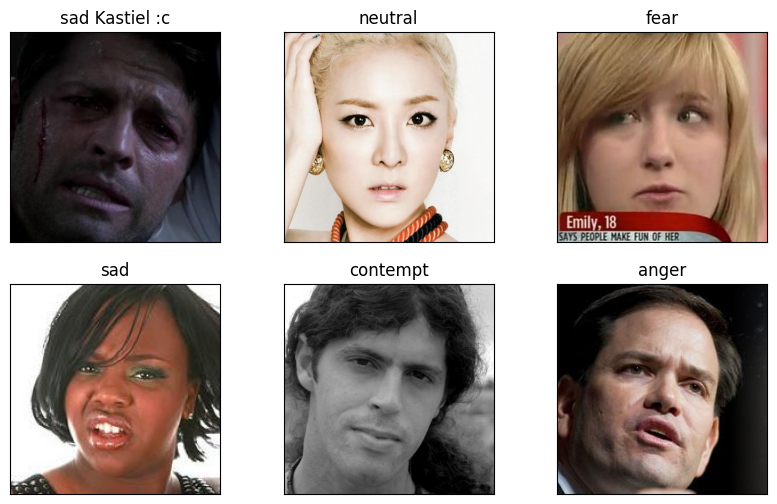

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))

img_paths = submission['image_path'].values[:6]
pred_ems = submission['emotion'].values[:6]
for i in range(6):
    img_name = './test_data/test_kaggle/'+str(i)+'.jpg'
    img = Image.open(img_name)
    ax[i//3][i%3].imshow(img)
    ax[i//3][i%3].set_xticks([])
    ax[i//3][i%3].set_yticks([])
    ax[i//3][i%3].set_title(pred_ems[i])

ax[0][0].set_title(pred_ems[0]+' Kastiel :c')

plt.show()